# Google Search Latency Experiment

### Scenario:
- Google runs an infra optimization.
- Mean latency drops by 4ms.

### Problem:
Design the full pipeline:



# Dependencies and Importing Data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
latency = pd.read_csv('dataset.csv')
latency.head(5)

,request_id,region,device_type,variant,latency_ms
0,0,US,mobile,treatment,93.091620
1,1,ASIA,mobile,control,267.938071
2,2,EU,mobile,treatment,69.316899
3,3,EU,mobile,treatment,75.789686
4,4,US,mobile,control,101.650827


# Data Assesment

In [5]:
latency.describe()

,request_id,latency_ms
count,100000.000000,100000.000000
mean,49999.500000,110.515716
std,28867.657797,64.834704
min,0.000000,35.663455
25%,24999.750000,81.356989
50%,49999.500000,90.192280
75%,74999.250000,100.688702
max,99999.000000,507.048180


In [6]:
latency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   request_id   100000 non-null  int64  
 1   region       100000 non-null  object 
 2   device_type  100000 non-null  object 
 3   variant      100000 non-null  object 
 4   latency_ms   100000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.8+ MB


No null values

In [7]:
print(latency['device_type'].value_counts())
print(latency['region'].value_counts())
print(latency['variant'].value_counts())

device_type
mobile     69793
desktop    30207
Name: count, dtype: int64
region
US      44978
EU      35117
ASIA    19905
Name: count, dtype: int64
variant
control      50085
treatment    49915
Name: count, dtype: int64


Mobile users are more than double with the difference of 39586. 
Little less than half of the samples comes from US region. It's little risky to say it the representation of whole globe. 
Control and treatment groups are near balanced.

In [8]:
latency.groupby(by=['variant'])['latency_ms'].mean()

variant
control      112.935085
treatment    108.088107
Name: latency_ms, dtype: float64

So the difference is really ~4ms.

# Statistical experiment

In [9]:
# Getting effect size
effect_size = (112.94 - 108.09)/64.83
effect_size

0.07481104426962817

In [10]:
from statsmodels.stats.power import TTestIndPower

alpha = 0.05           # significance level
power = 0.9            # desired statistical power

analysis = TTestIndPower()
sample_size = analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='two-sided'
)

print(f"Required sample size per group: {int(sample_size)}")

Required sample size per group: 3755


In [11]:
# split by variant
control = latency[latency["variant"] == "control"]['latency_ms']
treatment = latency[latency["variant"] == "treatment"]['latency_ms']

In [12]:
control_sample = control.sample(n=3755, random_state=42)
treatment_sample = treatment.sample(n=3755, random_state=42)

In [18]:
### Permutation test.

def permutation_test(x, y, n_permutations=10000, seed=42):
    rng = np.random.default_rng(seed)

    x = np.asarray(x)
    y = np.asarray(y)

    observed = np.mean(y) - np.mean(x)
    combined = np.concatenate([x, y])
    n_x = len(x)

    perm_stats = np.empty(n_permutations)

    for i in range(n_permutations):
        rng.shuffle(combined)
        x_perm = combined[:n_x]
        y_perm = combined[n_x:]
        perm_stats[i] = np.mean(y_perm) - np.mean(x_perm)

    count = np.sum(np.abs(perm_stats) >= abs(observed))
    p_value = (count + 1) / (len(perm_stats) + 1)

    return observed, p_value, perm_stats


In [19]:
observed, p_value, perm_stats = permutation_test(control_sample, treatment_sample)

In [20]:
print(f"p value: {p_value:.12f}")

p value: 0.000099990001


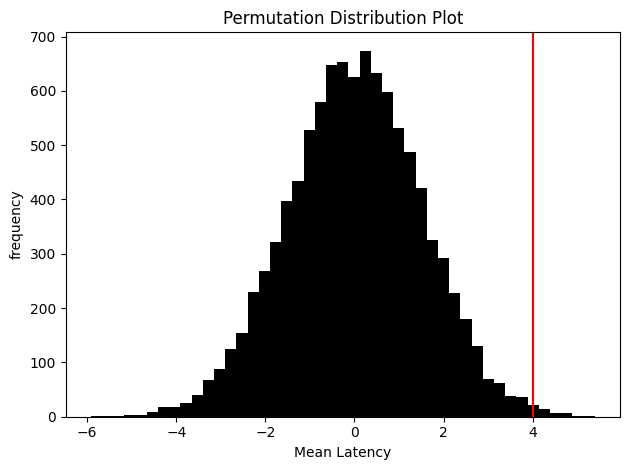

In [39]:
plt.hist(perm_stats, bins=45, color='black')
plt.axvline(x=4, color='red')
plt.title("Permutation Distribution Plot")
plt.xlabel("Mean Latency")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

p_value is very small. The signal is too strong!